In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

/home/zzq/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_df = pd.read_csv("train.csv")
train_df.shape

(30471, 292)

In [3]:
train_df.head()#默认取前5行

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

<function matplotlib.pyplot.show>

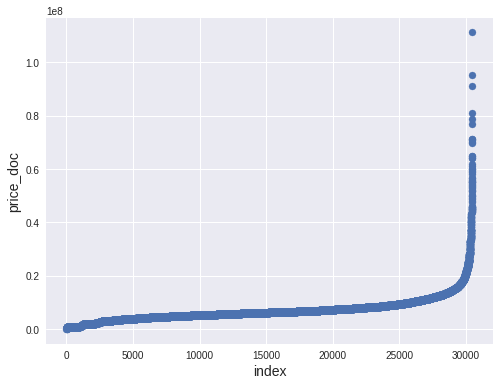

In [4]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]),np.sort(train_df.price_doc.values))
plt.xlabel("index",fontsize=14)
plt.ylabel("price_doc",fontsize=14)
plt.savefig('index_price.jpg')
plt.show

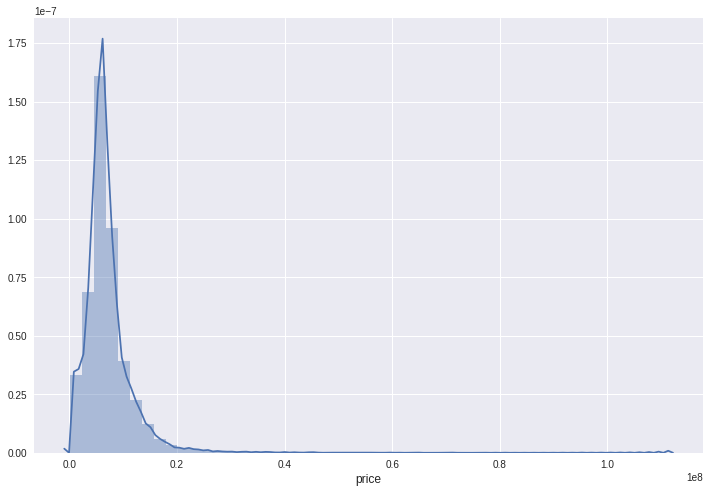

In [5]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.price_doc.values, bins=50, kde=True)#画方块图的时候可以用到sns的distplot函数
plt.xlabel('price', fontsize=12)
plt.savefig('price_histori.jpg')
plt.show()

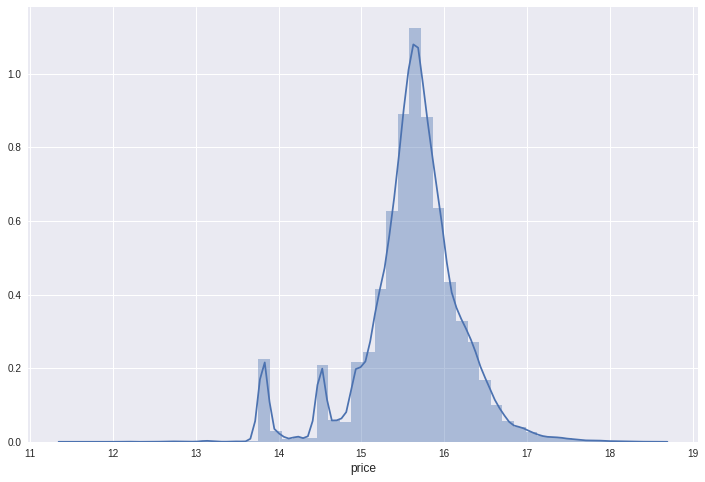

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

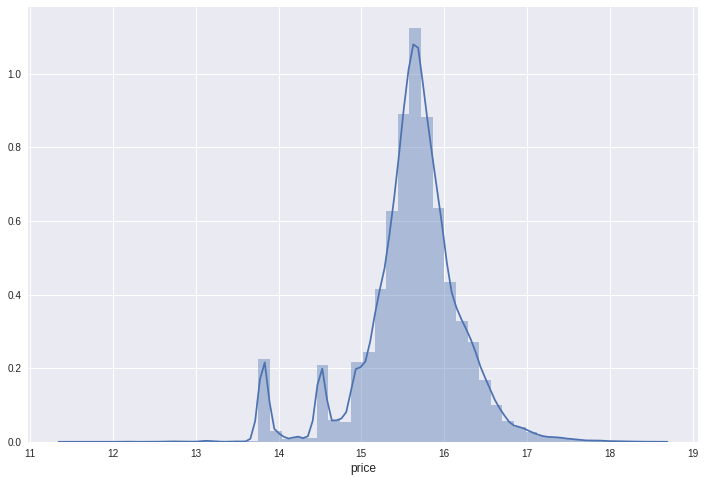

In [7]:


plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()



<function matplotlib.pyplot.show>

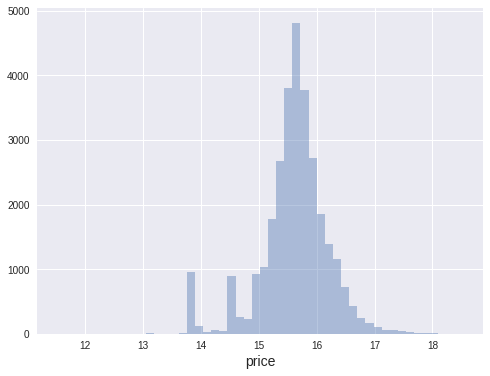

In [8]:
plt.figure(figsize=(8,6))
sns.distplot(np.log(train_df.price_doc.values),bins=50,kde=False)
#bin 是方块图的个数
plt.xlabel('price',fontsize=14)
#kde 控制是否显示核密度估计图
plt.show

In [10]:
train_df.describe()#对全局信息的一个整理，是以列作为操作单位，如果列多了，这样的效果就不会很好了

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_c

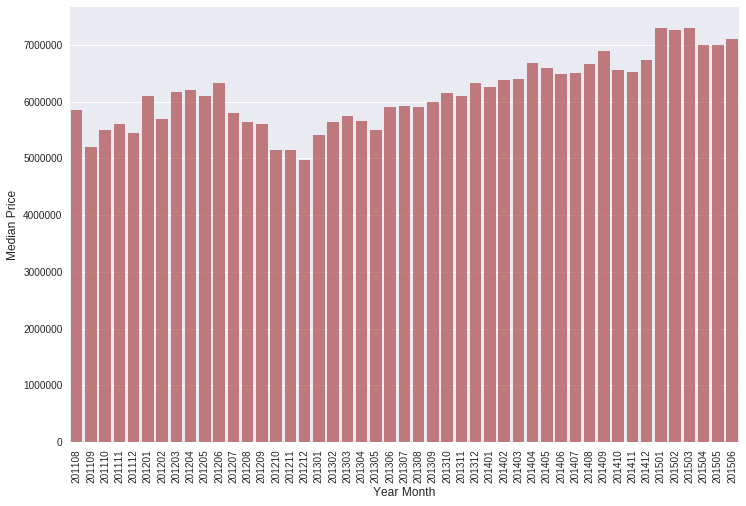

In [11]:
train_df['yearmonth'] = train_df['timestamp'].apply(lambda x: x[:4]+x[5:7])#将lamda函数应用到这个数据的每一行,
#将lamda函数应用于整个函数
#按照yearmonth这个index来分离price_doc
#后面一个方块是作用于那个dataframe的意思,然后.aggregate是用什么函数去作用
grouped_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()#将两个数据连接在一起
plt.figure(figsize=(12,8))
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])#estimator默认为平均值，
#可改为max,min
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [12]:
train_df = pd.read_csv("/home/zzq/kaggle/house/train.csv", parse_dates=['timestamp'])
dtype_df = train_df.dtypes.reset_index()#重新编排索引值
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()#reset_index(drop=True)
#drop是是否将生成的索引放回原来的值中
#reset_index和groupby函数合起来一起用，
#292个指标的属性，从这里我们可以看出，绝大部分指标都是数值类型。

,Column Type,Count
0,int64,157
1,datetime64[ns],1
2,float64,119
3,object,15


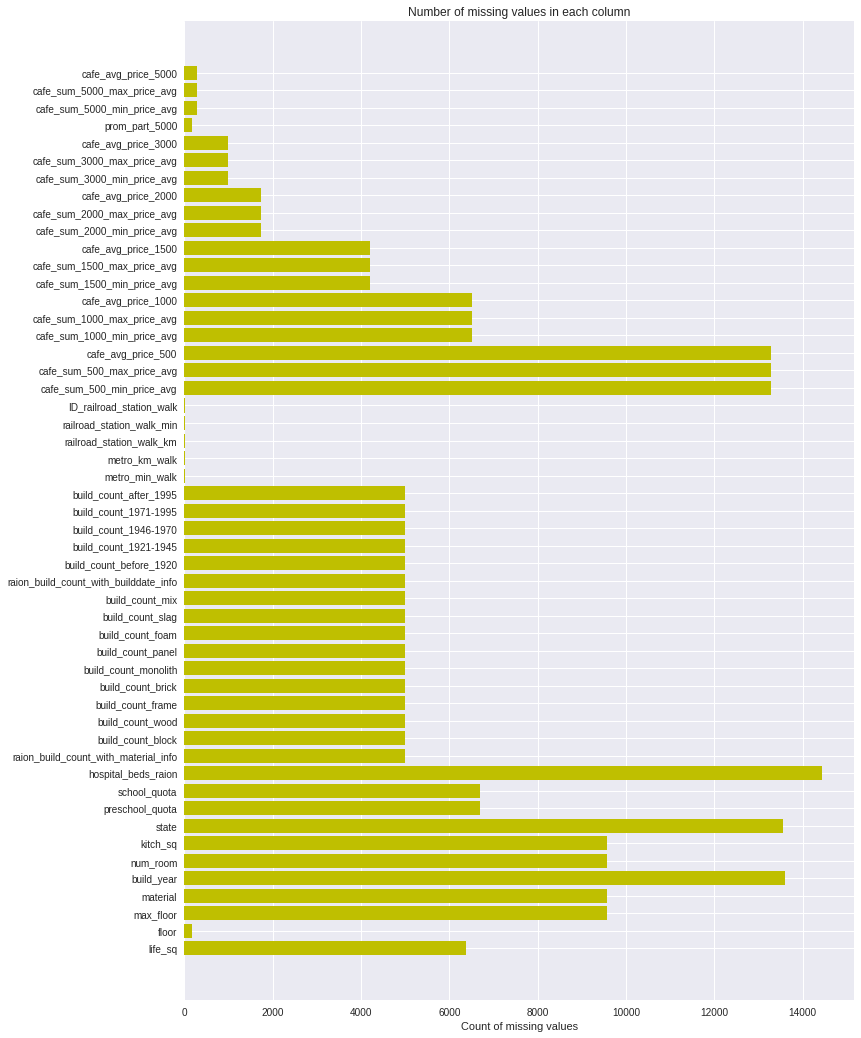

In [13]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
#isnull有空值的才执行
#0列1行
missing_df.columns = ['column_name', 'missing_count']
#赋值命名
missing_df = missing_df.ix[missing_df['missing_count']>0]#只有满足括号中条件的才留下
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [24]:
print missing_df.columns
# print missing_df
name_list=missing_df['column_name'].tolist()
print name_list
out=file('/home/zzq/kaggle/house/miss_column','a+')
for i in range(len(name_list)):
    out.write(name_list[i]+'\n')
out.close()

Index([u'column_name', u'missing_count'], dtype='object')
['life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state', 'preschool_quota', 'school_quota', 'hospital_beds_raion', 'raion_build_count_with_material_info', 'build_count_block', 'build_count_wood', 'build_count_frame', 'build_count_brick', 'build_count_monolith', 'build_count_panel', 'build_count_foam', 'build_count_slag', 'build_count_mix', 'raion_build_count_with_builddate_info', 'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995', 'build_count_after_1995', 'metro_min_walk', 'metro_km_walk', 'railroad_station_walk_km', 'railroad_station_walk_min', 'ID_railroad_station_walk', 'cafe_sum_500_min_price_avg', 'cafe_sum_500_max_price_avg', 'cafe_avg_price_500', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg', 'cafe_avg_price_1000', 'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500', 'cafe_sum_2000_min_pric

In [27]:
# print missing_df.loc(missing_df[0],'missing_count')
missing_df[0:3]

KeyError: 0

In [16]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()#按大小顺序，按照数值进行排序转成list
        lbl.fit(list(train_df[f].values)) 
        train_df[f] = lbl.transform(list(train_df[f].values))#转换为[0,1,2,....]
#将object属性的数值xian
train_y = train_df.price_doc.values
train_X = train_df.drop(["id", "timestamp", "price_doc"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)#columns就是每一列的列名
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
# plot the important features #
fig, ax = plt.subplots(figsize=(120,180))
xgb.plot_importance(model, height=0.8, ax=ax)
plt.show()

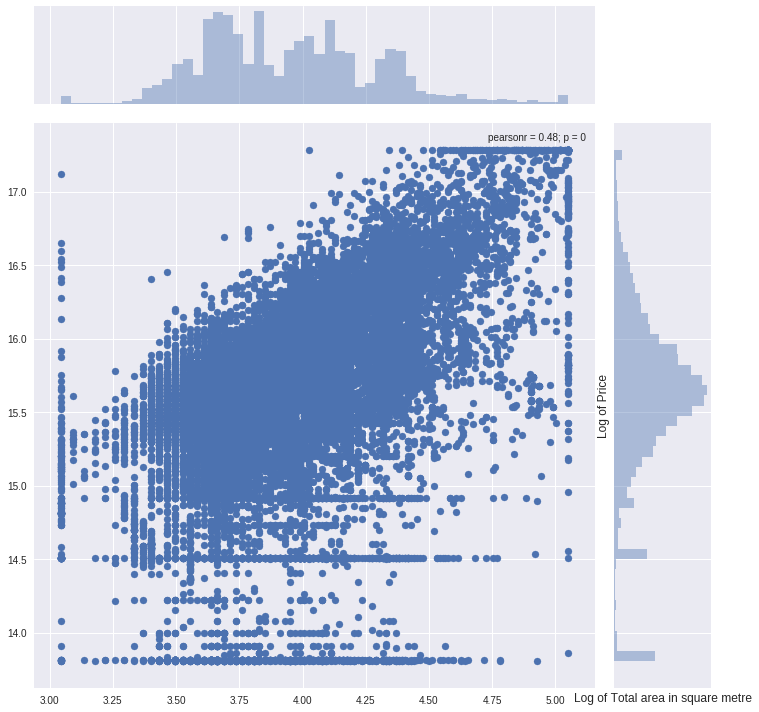

In [17]:
ulimit = np.percentile(train_df.price_doc.values, 99.5)#截取最大值到最小值差距的95%再加上最小值
llimit = np.percentile(train_df.price_doc.values, 0.5)#去除极大极小值的干扰
train_df['price_doc'].ix[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].ix[train_df['price_doc']<llimit] = llimit

col = "full_sq"
ulimit = np.percentile(train_df[col].values, 99.5)
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12))#在横竖方向上都显示值
sns.jointplot(x=np.log1p(train_df.full_sq.values), y=np.log1p(train_df.price_doc.values), size=10)#联合图表1
plt.ylabel('Log of Price', fontsize=12)
plt.xlabel('Log of Total area in square metre', fontsize=12)
plt.show()